In [2]:
# ============================================
# 1) IMPORT LIBRARY
# ============================================
import pandas as pd
import random
from collections import Counter

import torch
from torch import nn

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [3]:
# ==================================================
# 2) BACA DATA
# ==================================================
df = pd.read_csv("/content/cleaned_for_training_final (3).csv")

print("\n=== Step 2: Dataset Loaded ===")
print("Jumlah total data :", len(df))
print("\nDistribusi Label (SEBELUM SPLIT):")
print(df['label'].value_counts())
print("\nPersentase Label (SEBELUM SPLIT):")
print((df['label'].value_counts(normalize=True) * 100).round(2))



=== Step 2: Dataset Loaded ===
Jumlah total data : 7178

Distribusi Label (SEBELUM SPLIT):
label
0    4374
1    2804
Name: count, dtype: int64

Persentase Label (SEBELUM SPLIT):
label
0    60.94
1    39.06
Name: proportion, dtype: float64


In [4]:
from sklearn.model_selection import train_test_split

# ==================================================
# 3) SPLIT DATA (70:15:15) DENGAN STRATIFY
# ==================================================
train_df, test_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df["label"]
)

train_df, valid_df = train_test_split(
    train_df,
    test_size=0.1765,         # 0.1765 x 0.85 ≈ 0.15
    random_state=42,
    stratify=train_df["label"]
)

print("\n=== Step 3: Split Completed ===")
print("Train :", len(train_df), "|", round(len(train_df)/len(df)*100,2), "%")
print("Valid :", len(valid_df), "|", round(len(valid_df)/len(df)*100,2), "%")
print("Test  :", len(test_df),  "|", round(len(test_df)/len(df)*100,2), "%")

print("\nDistribusi TRAIN:")
print(train_df['label'].value_counts())
print((train_df['label'].value_counts(normalize=True) * 100).round(2))

print("\nDistribusi VALID:")
print(valid_df['label'].value_counts())
print((valid_df['label'].value_counts(normalize=True) * 100).round(2))

print("\nDistribusi TEST:")
print(test_df['label'].value_counts())
print((test_df['label'].value_counts(normalize=True) * 100).round(2))



=== Step 3: Split Completed ===
Train : 5024 | 69.99 %
Valid : 1077 | 15.0 %
Test  : 1077 | 15.0 %

Distribusi TRAIN:
label
0    3062
1    1962
Name: count, dtype: int64
label
0    60.95
1    39.05
Name: proportion, dtype: float64

Distribusi VALID:
label
0    656
1    421
Name: count, dtype: int64
label
0    60.91
1    39.09
Name: proportion, dtype: float64

Distribusi TEST:
label
0    656
1    421
Name: count, dtype: int64
label
0    60.91
1    39.09
Name: proportion, dtype: float64


In [ ]:
from collections import Counter
import pandas as pd

def apply_PRUS(df, label="label", target_ratio=1.5, seed=42):
    """
    Partial Random Undersampling (PRUS)

    target_ratio = mayoritas : minoritas (final)
    1.5 -> 1.5:1 (PARTIAL undersampling)

    Catatan:
    - PRUS hanya mengurangi kelas mayoritas (minoritas dipertahankan).
    - Jika target_ratio >= rasio asli, PRUS tidak dilakukan (karena sudah memenuhi).
    """
    vc = df[label].value_counts()
    majority = vc.idxmax()
    minority = vc.idxmin()

    df_maj = df[df[label] == majority]
    df_min = df[df[label] == minority]

    # target mayoritas setelah undersampling
    target_maj_size = int(len(df_min) * target_ratio)

    # Jika target mayoritas >= mayoritas asli, artinya tidak perlu undersampling
    if target_maj_size >= len(df_maj):
        return df.sample(frac=1, random_state=seed).reset_index(drop=True)

    # sample mayoritas (tanpa replacement)
    df_maj_down = df_maj.sample(n=target_maj_size, replace=False, random_state=seed)

    # gabungkan + shuffle
    df_prus = pd.concat([df_min, df_maj_down]).sample(frac=1, random_state=seed)
    return df_prus.reset_index(drop=True)


In [6]:
# ==================================================
# 5) PRUS DIAPLIKASIKAN KE TRAIN
#    misal target_ratio = 1.0 (hampir seimbang 1:1)
# ==================================================
train_prus = apply_PRUS(train_df, label="label", target_ratio=1.5, seed=42)
print(train_prus["label"].value_counts().sort_index())


print("\n=== Step 5: PRUS Applied ===")
print("SEBELUM PRUS:")
print(train_df['label'].value_counts(), "\n")
print("SESUDAH PRUS:")
print(train_prus['label'].value_counts(), "\n")

print("Persentase SEBELUM PRUS:")
print((train_df['label'].value_counts(normalize=True) * 100).round(2), "\n")

print("Persentase SESUDAH PRUS:")
print((train_prus['label'].value_counts(normalize=True) * 100).round(2))


label
0    2943
1    1962
Name: count, dtype: int64

=== Step 5: PRUS Applied ===
SEBELUM PRUS:
label
0    3062
1    1962
Name: count, dtype: int64 

SESUDAH PRUS:
label
0    2943
1    1962
Name: count, dtype: int64 

Persentase SEBELUM PRUS:
label
0    60.95
1    39.05
Name: proportion, dtype: float64 

Persentase SESUDAH PRUS:
label
0    60.0
1    40.0
Name: proportion, dtype: float64


In [7]:
# ============================================
# 4. Tokenizer IndoBERTweet
# ============================================
MODEL_NAME = "indolem/indobertweet-base-uncased"  # ganti kalau pakai repo lain

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 128
def tokenize_batch(texts):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt",
    )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
# fungsi tokenize HARUS pakai 'def', bukan 'f'
def tokenize_function(batch):
    return tokenizer(
        batch["clean_text"],          # pastikan nama kolom ini ada di CSV
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt",
    )


In [10]:
from datasets import Dataset

# ==================================================
# 8) CONVERT PANDAS → HF DATASET
# ==================================================
train_ds = Dataset.from_pandas(train_prus.reset_index(drop=True))
valid_ds = Dataset.from_pandas(valid_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

# tokenisasi
train_ds = train_ds.map(tokenize_function, batched=True)
valid_ds = valid_ds.map(tokenize_function, batched=True)
test_ds  = test_ds.map(tokenize_function, batched=True)

# buang kolom teks mentah (kalau ada)
cols_to_remove = [c for c in ["full_text", "clean_text", "__index_level_0__"] if c in train_ds.column_names]
train_ds = train_ds.remove_columns(cols_to_remove)
valid_ds = valid_ds.remove_columns(cols_to_remove)
test_ds  = test_ds.remove_columns(cols_to_remove)

# rename label → labels (standar HuggingFace)
if "label" in train_ds.column_names:
    train_ds = train_ds.rename_column("label", "labels")
    valid_ds = valid_ds.rename_column("label", "labels")
    test_ds  = test_ds.rename_column("label", "labels")

# set format tensor (PyTorch)
train_ds.set_format("torch")
valid_ds.set_format("torch")
test_ds.set_format("torch")

print("\n=== Step 8: Dataset Ready ===")
print("Train HF size:", len(train_ds))
print("Valid HF size:", len(valid_ds))
print("Test  HF size:", len(test_ds))
print("\nContoh sample train_ds[0]:")
print(train_ds[0])


Map:   0%|          | 0/4905 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]


=== Step 8: Dataset Ready ===
Train HF size: 4905
Valid HF size: 1077
Test  HF size: 1077

Contoh sample train_ds[0]:
{'labels': tensor(0), 'input_ids': tensor([    3,  1836,  2818,  1684,  7523,  2037,  3594,  6620,  8020,  2115,
         4951,  1806,  1580,  2137,  3354,  1975,  3524,  1718,  3482,  4660,
         1843, 18097,  1476,  1959,  2426,     4,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,   

In [11]:
# ============================================
# 6. Load model IndoBERTweet (tanpa class weight)
# ============================================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  # sarkas / non-sarkas
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1_macro, _ = precision_recall_fscore_support(
        labels, preds,
        average="macro",
        zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_macro": f1_macro,
    }

In [ ]:
# =====================================================
# 6. Random Search Space (MAX 8 Trial)
# =====================================================
param_space = {
    "learning_rate": [5e-5, 3e-5, 2e-5, 1e-5],
    "batch_size": [8, 16, 32],
    "num_train_epochs": [3, 4, 5]
}

# Random pilihan max 8 kombinasi
trials = []
while len(trials) < 8:
    lr = random.choice(param_space["learning_rate"])
    bs = random.choice(param_space["batch_size"])
    ep = random.choice(param_space["num_train_epochs"])
    combo = (lr, bs, ep)
    if combo not in trials:
        trials.append(combo)

print("Total Random Trials Dipakai:", len(trials))
print(trials)



Total Random Trials Dipakai: 8
[(5e-05, 8, 5), (2e-05, 8, 3), (3e-05, 32, 3), (5e-05, 32, 4), (5e-05, 8, 3), (3e-05, 8, 5), (5e-05, 32, 3), (1e-05, 8, 4)]


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, EarlyStoppingCallback
import random

model_name = "indolem/indobertweet-base-uncased"
best_f1 = 0.0
best_params = None
results = []

# misal all_combos sudah kamu buat dan dibatasi N_TRIALS
# all_combos = [...]
# all_combos = all_combos[:N_TRIALS]

for i, (lr, bs, ep) in enumerate(trials, start=1):
    print(f"\n==================== Percobaan {i} ====================")
    print(f"lr={lr}, bs={bs}, epoch={ep}")

    # reset model tiap trial
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    ).to(device)

    args = TrainingArguments(
        output_dir=f"./tmp_indobertweet_prus{i}",
        learning_rate=lr,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs,
        num_train_epochs=ep,
        eval_strategy="epoch",      # ✅ perbaiki ini
        logging_strategy="epoch",
        save_strategy="no",
        load_best_model_at_end=False,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        report_to="none",
        seed=42
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=2,
                early_stopping_threshold=0.0
            )
        ]
    )

    trainer.train()

    # ambil log per epoch
    history = trainer.state.log_history
    f1_per_epoch = [h["eval_f1_macro"] for h in history if "eval_f1_macro" in h]
    best_f1_trial = max(f1_per_epoch)
    best_epoch_idx = f1_per_epoch.index(best_f1_trial) + 1

    results.append({
        "trial": i,
        "learning_rate": lr,
        "batch_size": bs,
        "num_train_epochs": ep,
        "best_epoch": best_epoch_idx,
        "f1_macro": best_f1_trial
    })

    print(f"➡️ F1 Macro terbaik percobaan {i}: {best_f1_trial:.4f} (epoch {best_epoch_idx})")

    if best_f1_trial > best_f1:
        best_f1 = best_f1_trial
        best_params = {
            "learning_rate": lr,
            "batch_size": bs,
            "num_train_epochs": ep,
            "best_epoch": best_epoch_idx
        }

print("\n==================== Hasil Random Search (PRUS + Class Weight) ====================")
print("BEST:", best_params)
print("BEST F1:", best_f1)



==================== Percobaan 1 ====================
lr=5e-05, bs=8, epoch=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2916589469.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.507100,0.477130,0.812442,0.804622,0.798386,0.801117
2,0.340900,0.523417,0.821727,0.821932,0.798775,0.806622
3,0.165200,0.880266,0.825441,0.817915,0.830755,0.821034
4,0.064100,1.016632,0.828227,0.818942,0.823681,0.821028
5,0.031400,1.106225,0.820799,0.812795,0.824816,0.815996


➡️ F1 Macro terbaik percobaan 1: 0.8210 (epoch 3)

==================== Percobaan 2 ====================
lr=2e-05, bs=8, epoch=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2916589469.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.498600,0.420338,0.818013,0.808383,0.812744,0.810312
2,0.356100,0.493766,0.822656,0.814673,0.826766,0.817902
3,0.255500,0.607403,0.816156,0.809362,0.822707,0.811954


➡️ F1 Macro terbaik percobaan 2: 0.8179 (epoch 2)

==================== Percobaan 3 ====================
lr=3e-05, bs=32, epoch=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2916589469.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.491900,0.430573,0.802228,0.799166,0.813827,0.799119
2,0.339900,0.455585,0.809656,0.803914,0.817797,0.805788
3,0.233500,0.475144,0.812442,0.806086,0.819658,0.808370


➡️ F1 Macro terbaik percobaan 3: 0.8084 (epoch 3)

==================== Percobaan 4 ====================
lr=5e-05, bs=32, epoch=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2916589469.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.489600,0.403318,0.826370,0.817057,0.824710,0.820039
2,0.308000,0.490975,0.807799,0.804411,0.819251,0.804685
3,0.156000,0.524308,0.823584,0.814182,0.821572,0.817086


➡️ F1 Macro terbaik percobaan 4: 0.8200 (epoch 1)

==================== Percobaan 5 ====================
lr=5e-05, bs=8, epoch=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2916589469.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.499400,0.453243,0.810585,0.800730,0.806647,0.803173
2,0.321100,0.591110,0.833798,0.827395,0.821022,0.823845
3,0.148200,0.835831,0.819870,0.813554,0.827458,0.815959


➡️ F1 Macro terbaik percobaan 5: 0.8238 (epoch 2)

==================== Percobaan 6 ====================
lr=3e-05, bs=8, epoch=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2916589469.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.491800,0.442088,0.812442,0.806225,0.795408,0.799764
2,0.332600,0.501713,0.833798,0.827888,0.820171,0.823512
3,0.192100,0.857962,0.816156,0.810062,0.823984,0.812268
4,0.094800,0.988825,0.825441,0.816291,0.825224,0.819525


➡️ F1 Macro terbaik percobaan 6: 0.8235 (epoch 2)

==================== Percobaan 7 ====================
lr=5e-05, bs=32, epoch=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2916589469.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.491700,0.414710,0.812442,0.805623,0.818808,0.808155
2,0.337200,0.441671,0.807799,0.804411,0.819251,0.804685
3,0.194200,0.464104,0.822656,0.815196,0.828043,0.818233


➡️ F1 Macro terbaik percobaan 7: 0.8182 (epoch 3)

==================== Percobaan 8 ====================
lr=1e-05, bs=8, epoch=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2916589469.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.502600,0.432460,0.807799,0.799320,0.810317,0.802402
2,0.385700,0.438886,0.830084,0.821064,0.830311,0.824385
3,0.308600,0.557792,0.814299,0.810129,0.825012,0.811061
4,0.254700,0.570982,0.823584,0.816227,0.829230,0.819238


➡️ F1 Macro terbaik percobaan 8: 0.8244 (epoch 2)

==================== Hasil Random Search (PRUS + Class Weight) ====================
BEST: {'learning_rate': 1e-05, 'batch_size': 8, 'num_train_epochs': 4, 'best_epoch': 2}
BEST F1: 0.8243854323247137


Manual

In [ ]:
import pandas as pd

df_rs = pd.DataFrame(results).sort_values(by="f1_macro", ascending=False)
print(df_rs.head())  # lihat 5 kombinasi terbaik

# simpan hasil random search
df_rs.to_csv("randomsearch_prus_classweight_indobertweet.csv", index=False)


   trial  learning_rate  batch_size  num_train_epochs  best_epoch  f1_macro
7      8        0.00001           8                 4           2  0.824385
4      5        0.00005           8                 3           2  0.823845
5      6        0.00003           8                 5           2  0.823512
0      1        0.00005           8                 5           3  0.821034
3      4        0.00005          32                 4           1  0.820039


In [ ]:
print("Best params:", best_params)
print("Best F1:", best_f1)


Best params: {'learning_rate': 1e-05, 'batch_size': 8, 'num_train_epochs': 4, 'best_epoch': 2}
Best F1: 0.8243854323247137


In [13]:
best_params = {'learning_rate': 1e-05, 'batch_size': 8}
print("Defined best_params:", best_params)

Defined best_params: {'learning_rate': 1e-05, 'batch_size': 8, 'num_train_epochs': 4, 'best_epoch': 2}


In [19]:
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    EarlyStoppingCallback,
)

# ambil hyperparameter terbaik dari random search
best_lr     = best_params["learning_rate"]
best_bs     = best_params["batch_size"]

print("Best params:", best_params)

# model baru untuk training final
model_final = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

args_final = TrainingArguments(
    output_dir="./indobertweet_prus_best",
    learning_rate=best_lr,
    per_device_train_batch_size=best_bs,
    per_device_eval_batch_size=best_bs,
    num_train_epochs=3,          # train sampai epoch optimal
    eval_strategy="epoch",          # ✅ diperbaiki
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    weight_decay=0.01,                    # regularisasi biar ga makin overfit
    report_to="none",
    seed=42,
)

trainer_final = Trainer(
    model=model_final,
    args=args_final,
    train_dataset=train_ds,               # pastikan ini sudah PRUS
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3     # stop cepat kalau mulai overfit
        )
    ]
)

trainer_final.train()

# simpan model & tokenizer buat dipakai lagi / lampiran skripsi
save_dir = "./indobertweet_prus_classweight_best"
trainer_final.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print("Model final disimpan di:", save_dir)


Best params: {'learning_rate': 1e-05, 'batch_size': 8, 'num_train_epochs': 4, 'best_epoch': 2}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4274708119.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_final = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.484600,0.415276,0.818942,0.814349,0.800743,0.806017
2,0.373500,0.449125,0.829155,0.821173,0.818913,0.819991
3,0.316000,0.485928,0.819870,0.810331,0.814269,0.812101


Model final disimpan di: ./indobertweet_prus_classweight_best


In [20]:
import pandas as pd

# evaluasi
eval_valid = trainer_final.evaluate(eval_dataset=valid_ds)
eval_test  = trainer_final.evaluate(eval_dataset=test_ds)

# pilih metrik yang mau ditampilkan
keep_keys = [
    "eval_loss",
    "eval_accuracy",
    "eval_precision",
    "eval_recall",
    "eval_f1_macro",
    "epoch"
]

def filter_metrics(dct, name):
    data = {"Dataset": name}
    for k in keep_keys:
        data[k] = dct.get(k, None)
    return data

rows = [
    filter_metrics(eval_valid, "Valid"),
    filter_metrics(eval_test,  "Test")
]

df_eval = pd.DataFrame(rows)

# urutkan kolom + rename biar lebih enak dibaca
df_eval = df_eval[[
    "Dataset",
    "eval_loss",
    "eval_accuracy",
    "eval_precision",
    "eval_recall",
    "eval_f1_macro",
    "epoch"
]].rename(columns={
    "eval_loss": "Loss",
    "eval_accuracy": "Accuracy",
    "eval_precision": "Precision",
    "eval_recall": "Recall",
    "eval_f1_macro": "F1 Macro",
    "epoch": "Epoch"
})

# bulatkan 4 desimal untuk metrik numerik
for col in ["Loss", "Accuracy", "Precision", "Recall", "F1 Macro"]:
    df_eval[col] = df_eval[col].astype(float).round(4)

df_eval = df_eval.set_index("Dataset")
df_eval


,Loss,Accuracy,Precision,Recall,F1 Macro,Epoch
Dataset,,,,,,
Valid,0.4491,0.8292,0.8212,0.8189,0.8200,3.0
Test,0.3907,0.8440,0.8377,0.8328,0.8351,3.0


In [16]:
import pandas as pd

log_hist = pd.DataFrame(trainer_final.state.log_history)


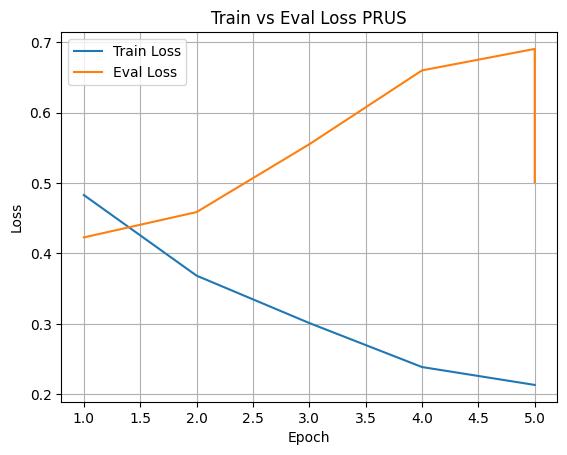

In [21]:
import matplotlib.pyplot as plt

# Filter for training logs (where 'loss' is present)
train_logs = log_hist[log_hist["loss"].notna()]
# Filter for evaluation logs (where 'eval_loss' is present)
eval_logs = log_hist[log_hist["eval_loss"].notna()]

plt.plot(train_logs["epoch"], train_logs["loss"], label="Train Loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Eval Loss PRUS")
plt.legend()
plt.grid(True)
plt.show()

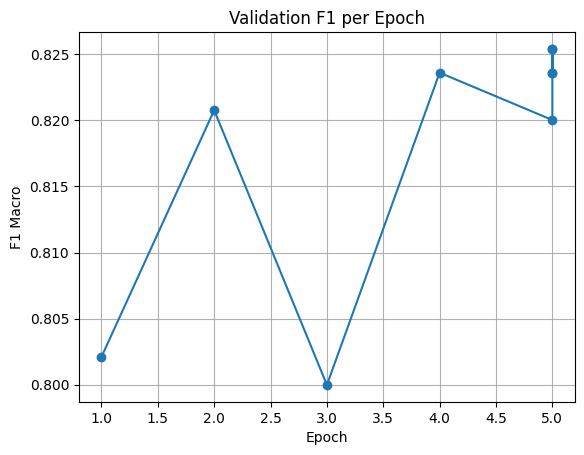

In [ ]:
eval_f1 = log_hist[log_hist["eval_f1_macro"].notna()]

plt.plot(eval_f1["epoch"], eval_f1["eval_f1_macro"], marker='o')
plt.xlabel("Epoch")
plt.ylabel("F1 Macro")
plt.title("Validation F1 per Epoch")
plt.grid(True)
plt.show()



📊 Classification Report (TEST):
              precision    recall  f1-score   support

non-sarkasme     0.8631    0.8841    0.8735       656
    sarkasme     0.8123    0.7815    0.7966       421

    accuracy                         0.8440      1077
   macro avg     0.8377    0.8328    0.8351      1077
weighted avg     0.8433    0.8440    0.8434      1077



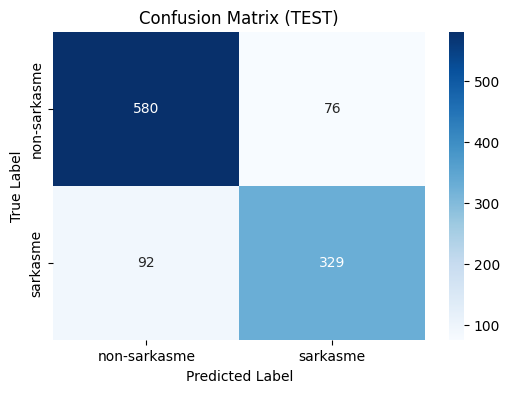

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

pred_test = trainer_final.predict(test_ds)
y_pred = np.argmax(pred_test.predictions, axis=1)
y_true = pred_test.label_ids

# Print classification report
print("\n📊 Classification Report (TEST):")
print(classification_report(y_true, y_pred, target_names=["non-sarkasme", "sarkasme"], digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["non-sarkasme", "sarkasme"],
            yticklabels=["non-sarkasme", "sarkasme"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (TEST)")
plt.show()

In [ ]:
sentences = [
    "Bagus banget nih! Luar biasa! aku juga mau #kaburajadulu ke thailand",
    "pemerintah udah #kaburajadulu masalah negara, kita kapan?",
    "kapan ya bisa #kaburajadulu",
    "Pemerintah selalu bikin rakyat sengasara #kaburajadulu"]

inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt").to(device)
outputs = model_final(**inputs)
preds = outputs.logits.argmax(dim=1)

for s, p in zip(sentences, preds):
    print(s, "=>", "Sarkasme" if p.item()==1 else "Non-Sarkasme")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Bagus banget nih! Luar biasa! aku juga mau #kaburajadulu ke thailand => Non-Sarkasme
pemerintah udah #kaburajadulu masalah negara, kita kapan? => Sarkasme
kapan ya bisa #kaburajadulu => Non-Sarkasme
Pemerintah selalu bikin rakyat sengasara #kaburajadulu => Sarkasme


In [ ]:
save_dir = "./model_prus_final"

trainer_final.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print("Model & tokenizer disimpan ke:", save_dir)


Model & tokenizer disimpan ke: ./model_prus_final


ROC–AUC Score: 0.9047


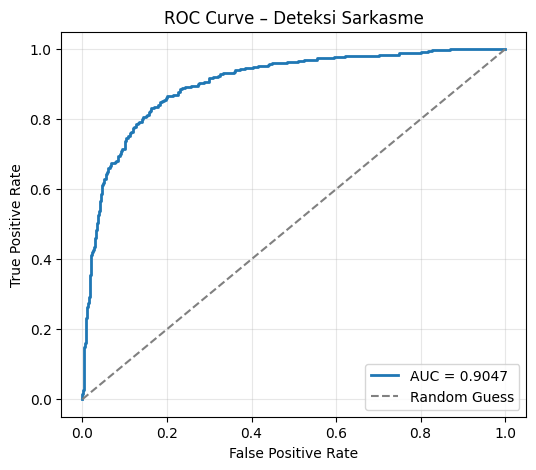

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

pred_test = trainer_final.predict(test_ds)
logits = pred_test.predictions
y_true = pred_test.label_ids

probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
y_score = probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

print(f"ROC–AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("ROC Curve – Deteksi Sarkasme")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

thresholds = np.arange(0.1, 0.91, 0.05)  # dari 0.10 sampai 0.90
results_thresh = []

for thr in thresholds:
    y_pred_thr = (probs[:, 1] >= thr).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred_thr,
        average=None,            # kita ambil per-class
        labels=[0, 1],
        zero_division=0
    )

    # index 1 = kelas Sarkasme
    prec_sarkas = precision[1]
    rec_sarkas  = recall[1]
    f1_sarkas   = f1[1]

    results_thresh.append({
        "threshold": thr,
        "precision_sarkas": prec_sarkas,
        "recall_sarkas": rec_sarkas,
        "f1_sarkas": f1_sarkas
    })

# ubah ke DataFrame biar enak dibaca
import pandas as pd

df_thresh = pd.DataFrame(results_thresh)
print(df_thresh)

# cari threshold dengan F1 Sarkasme terbaik
best_row = df_thresh.loc[df_thresh["f1_sarkas"].idxmax()]
print("\n=== Threshold Terbaik (berdasarkan F1 Sarkasme) ===")
print(f"Threshold          : {best_row['threshold']:.2f}")
print(f"Precision Sarkasme : {best_row['precision_sarkas']:.4f}")
print(f"Recall Sarkasme    : {best_row['recall_sarkas']:.4f}")
print(f"F1 Sarkasme        : {best_row['f1_sarkas']:.4f}")


    threshold  precision_sarkas  recall_sarkas  f1_sarkas
0        0.10          0.709125       0.885986   0.787751
1        0.15          0.712355       0.876485   0.785942
2        0.20          0.720472       0.869359   0.787944
3        0.25          0.728543       0.866983   0.791757
4        0.30          0.734280       0.859857   0.792123
5        0.35          0.740206       0.852732   0.792494
6        0.40          0.746862       0.847981   0.794216
7        0.45          0.748401       0.833729   0.788764
8        0.50          0.758099       0.833729   0.794118
9        0.55          0.764192       0.831354   0.796359
10       0.60          0.768374       0.819477   0.793103
11       0.65          0.773243       0.809976   0.791183
12       0.70          0.781106       0.805226   0.792982
13       0.75          0.787736       0.793349   0.790533
14       0.80          0.793765       0.786223   0.789976
15       0.85          0.804938       0.774347   0.789346
16       0.90 